# Load and Inspect Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\dimma\OneDrive\Υπολογιστής\Ο.Π.Α\Unsupervised Learning\Εργασια Ενοτητας 1\mall_customers.csv')
df.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
131,132,Male,39,71,75
184,185,Female,41,99,39
64,65,Male,63,48,51
176,177,Male,58,88,15
129,130,Male,38,71,75
65,66,Male,18,48,59
12,13,Female,58,20,15
93,94,Female,40,60,40
144,145,Male,25,77,12
83,84,Female,46,54,44


In [3]:
# We Drop the CustomerID column
df.drop(columns=['CustomerID'], inplace=True)

In [4]:
#Checking the number of rows, columns data type and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [5]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


# Univariate Analysis

In [6]:
#We create a function for each numeric feature



def histogram_boxplot(df, column, bins=8, color='green', figsize=(10, 7)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    # Histogram
    df[column].hist(bins=bins, ax=ax1, color=color, edgecolor='black')
    ax1.set_title(f'{column} - Histogram')


    # Boxplot
    df.boxplot(column=column, ax=ax2, vert=False)
    ax2.set_title(f'{column} - Boxplot')

    plt.tight_layout()
    plt.show()


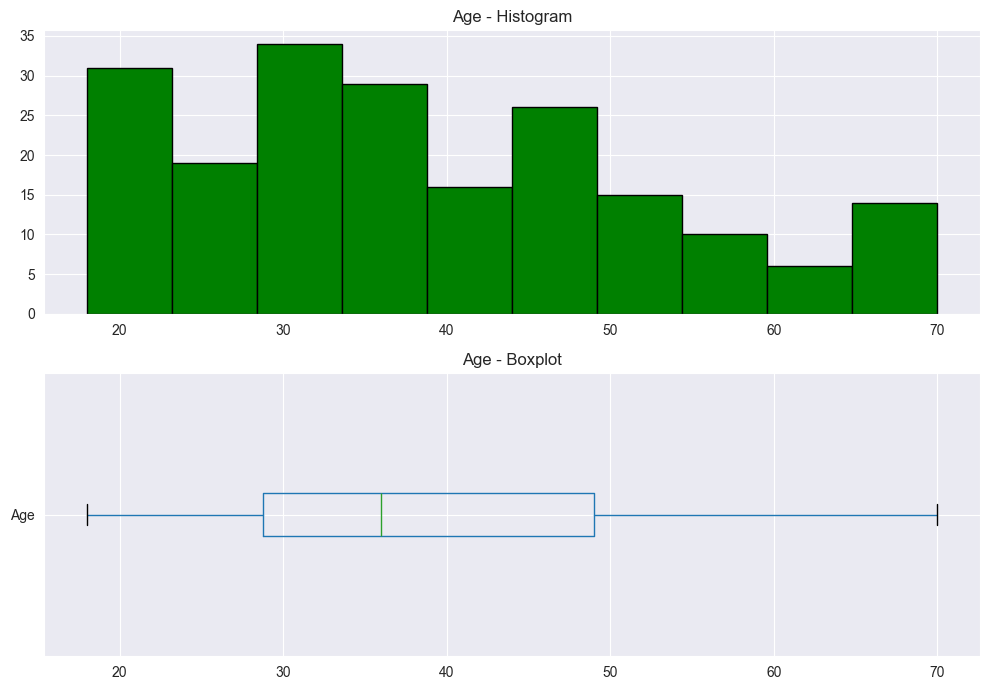

In [7]:
histogram_boxplot(df, 'Age', bins=10)

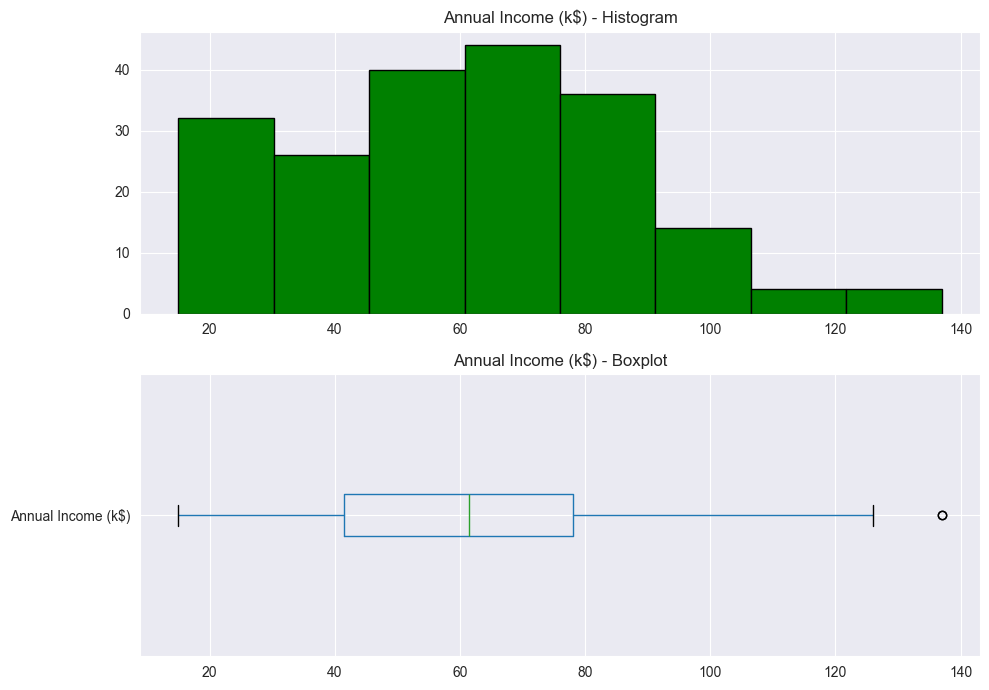

In [8]:
histogram_boxplot(df, 'Annual Income (k$)')

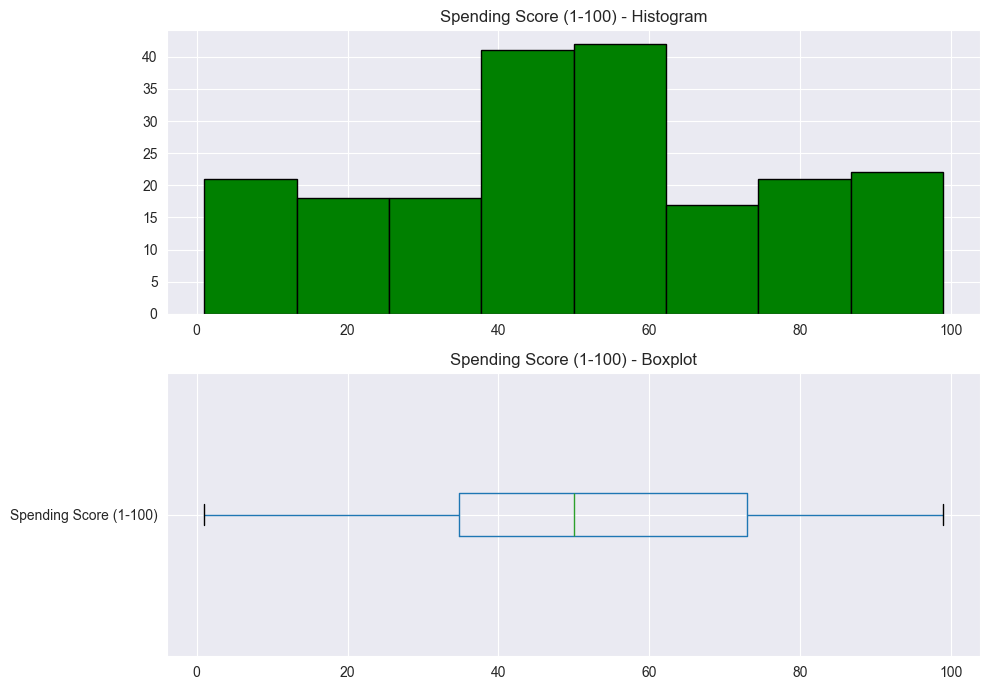

In [9]:
histogram_boxplot(df, 'Spending Score (1-100)')

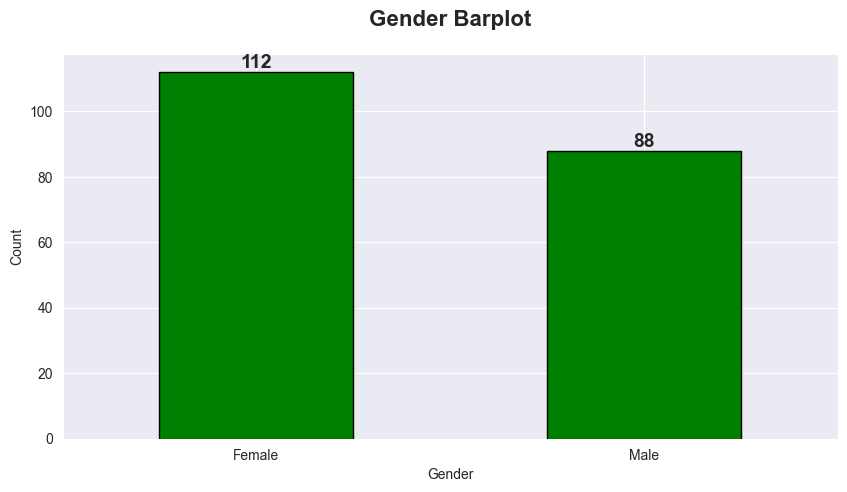

In [10]:
# A bar plot for the categorical feature Gender.
(df['Gender'].value_counts()
                     .plot(kind='bar', figsize=(10,5), color='green', edgecolor='black'))
plt.title('Gender Barplot', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, val in enumerate(df['Gender'].value_counts()):
    plt.text(i , val , str(val), ha='center', va='bottom', fontsize=14, fontweight='bold'  )
plt.show()

In [11]:
# We create a function to detect outliers
def detect_outliers(df, column_name):
# Calculating Q1, Q2, IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Setting Boundaries
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # We detect the Outliers
    outliers_mask = (df[column_name] < lower) | (df[column_name] > upper)

    # Calculate the sum, and percentage of outliers
    outliers_count = outliers_mask.sum()
    total_count = len(df)
    outliers_percentage = (outliers_count / total_count) * 100

    print(f"Column: '{column_name}'")
    print(f"- Number of outliers: {outliers_count}")
    print(f"- Percentage of outliers: {outliers_percentage:.2f}%")
    print("-" * 30)

    if outliers_count > 0:
        print("\nOutliers row")
        # print only the outliers
        print(df[outliers_mask])
    else:
        print("\nNo outliers in this column")

    print("-" * 40)

In [12]:
detect_outliers(df, 'Age')

Column: 'Age'
- Number of outliers: 0
- Percentage of outliers: 0.00%
------------------------------

No outliers in this column
----------------------------------------


In [13]:
detect_outliers(df, 'Annual Income (k$)')

Column: 'Annual Income (k$)'
- Number of outliers: 2
- Percentage of outliers: 1.00%
------------------------------

Outliers row
    Gender  Age  Annual Income (k$)  Spending Score (1-100)
198   Male   32                 137                      18
199   Male   30                 137                      83
----------------------------------------


In [14]:
detect_outliers(df, 'Spending Score (1-100)')

Column: 'Spending Score (1-100)'
- Number of outliers: 0
- Percentage of outliers: 0.00%
------------------------------

No outliers in this column
----------------------------------------


### We conclude that there are no significant outliers

# MultiVariate Analysis

In [15]:
import seaborn as sns

In [16]:
#We Encode the Gender into Numeric column 0 and 1
df['Gender'].value_counts()
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

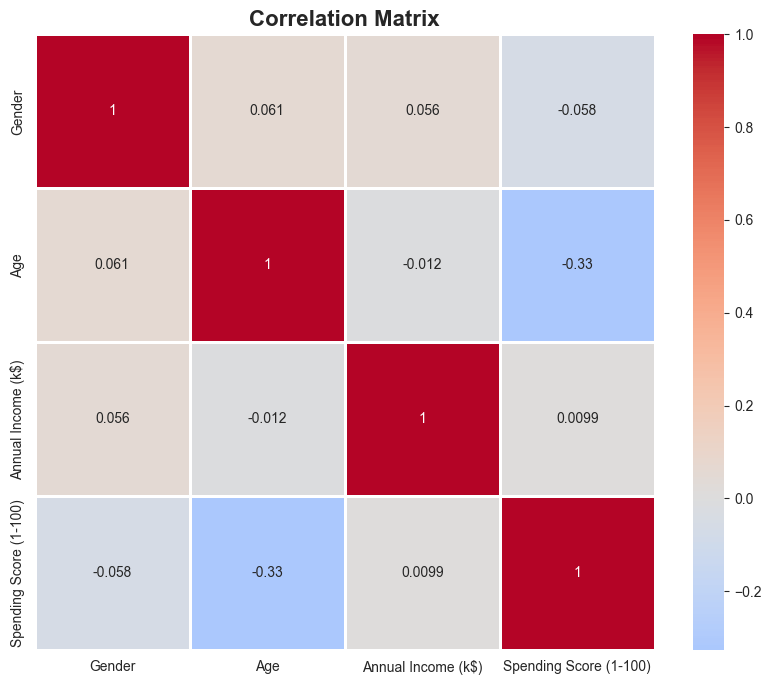

In [17]:
#Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', center=0, linewidths=1)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

#### The only feature that has a small significance seems to be the Age with -0.33

# Kmeans Clustering

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [19]:
# We create a function for scaling.
def scale_features(df, features_list):
    """Implements StandardScaler in the selected features"""
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features_list])
    return scaled_data

#  A function to evaluate with Elbow method & Silhouette Score
def evaluate_optimal_kappa(data, max_k=10):
    """We calculate inertia and silhouette score for optimal K"""
    wcss = []  #wcss=Within Clusters Sum of Square
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        # Tuning the parameters
        model = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
        labels = model.fit_predict(data)

        wcss.append(model.inertia_)
        silhouette_scores.append(silhouette_score(data, labels))

    # Drawing the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Elbow Plot
    ax1.plot(k_range, wcss, marker='o', color='blue')
    ax1.set_title('Elbow Method (Inertia)')
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('WCSS')

    # Silhouette Plot
    ax2.plot(k_range, silhouette_scores, marker='s', color='red')
    ax2.set_title('Silhouette Score')
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('Score')

    plt.show()




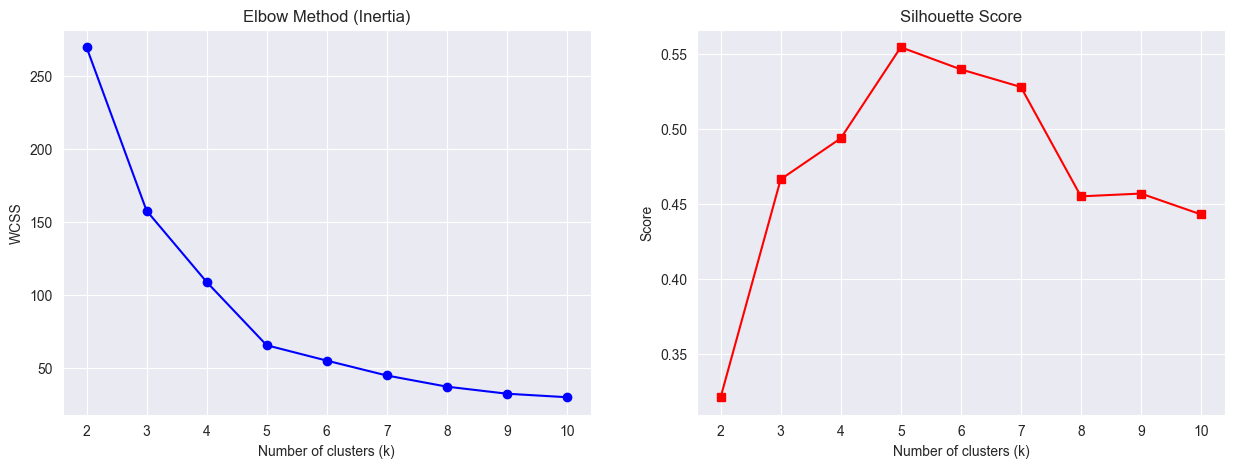

In [20]:
# Selection of the features Age and Annual Income. First we want the Optimal K
features = ['Annual Income (k$)', 'Spending Score (1-100)']

#  Scaling
X_scaled = scale_features(df, features)

#  Evaluation
evaluate_optimal_kappa(X_scaled)

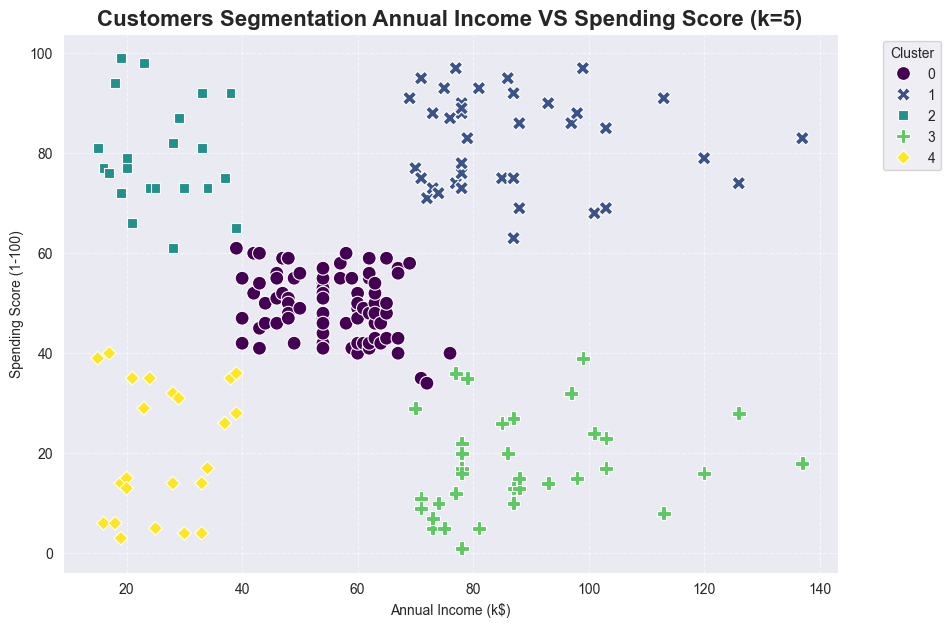

In [21]:
# A function for the  Clustering
def perform_clustering(df, X_scaled, k=5):
    """
    Performs clustering and draws the results.
    """
    # Executing the Kmeans
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # We add the Clusters in the Initial Dataframe for the Marketing team
    df['Cluster'] = cluster_labels

    # Drawing the 2D Scatter Plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=df['Annual Income (k$)'],
        y=df['Spending Score (1-100)'],
        hue=df['Cluster'],
        palette='viridis',
        s=100,
        style=df['Cluster']
    )

    # The Titles in the Scatter Plot
    plt.title(f'Customers Segmentation Annual Income VS Spending Score (k={k})', fontsize=16, fontweight='bold')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return df

# Executing The Function
df = perform_clustering(df, X_scaled, k=5)

In [22]:
def cluster_means(df):
    """
    Calculates the mean, median and standard deviation within the clusters.
    """
     # We Calculate the means into the Clusters
    cluster_analysis = df.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)', "Age"]].agg(['mean','median','std'])

    print("Describe Statistics of the clusters: :")
    print(cluster_analysis)
    print("-" * 30)

cluster_means(df)



Describe Statistics of the clusters: :
        Annual Income (k$)                   Spending Score (1-100)         \
                      mean median        std                   mean median   
Cluster                                                                      
0                55.296296   54.0   8.988109              49.518519   50.0   
1                86.538462   79.0  16.312485              82.128205   83.0   
2                25.727273   24.5   7.566731              79.363636   77.0   
3                88.200000   85.0  16.399067              17.114286   16.0   
4                26.304348   25.0   7.893811              20.913043   17.0   

                          Age                    
               std       mean median        std  
Cluster                                          
0         6.530909  42.716049   46.0  16.447822  
1         9.364489  32.692308   32.0   3.728650  
2        10.504174  25.272727   23.5   5.257030  
3         9.952154  41.114286   42.0

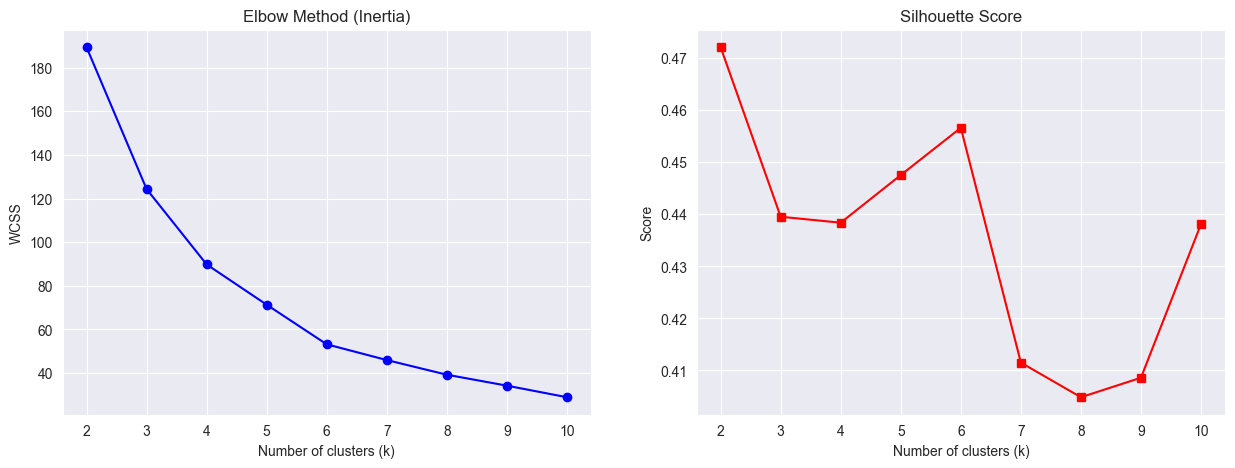

In [23]:
# We select Age VS Spending Score
features_age_spending = ['Age', 'Spending Score (1-100)']

#  Scaling
X_age_scaled = scale_features(df, features_age_spending)
# Selecting Optimal K
evaluate_optimal_kappa(X_age_scaled)

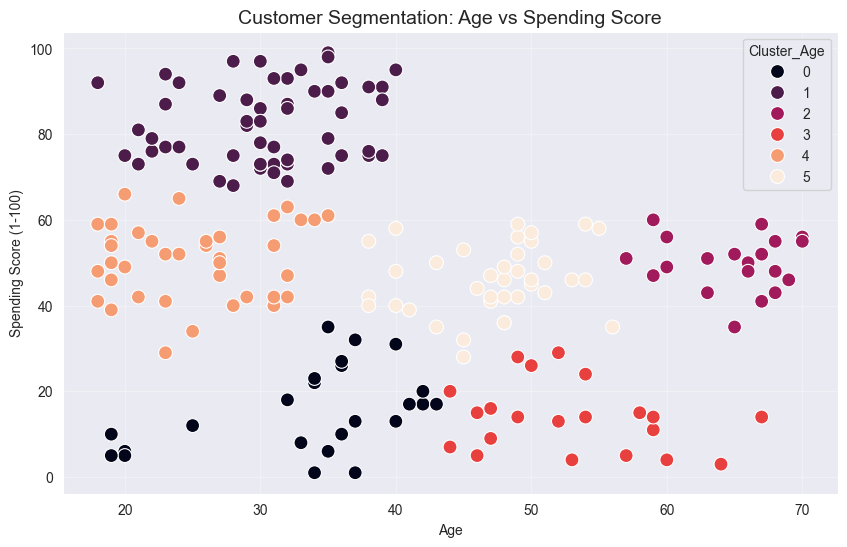

In [24]:
#  Clustering & Plotting
def age_spending_clusters(df, X_scaled, k=6):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    df['Cluster_Age'] = kmeans.fit_predict(X_scaled)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df['Age'],
        y=df['Spending Score (1-100)'],
        hue=df['Cluster_Age'],
        palette='rocket',
        s=100
    )
    plt.title('Customer Segmentation: Age vs Spending Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

age_spending_clusters(df, X_age_scaled, k=6)

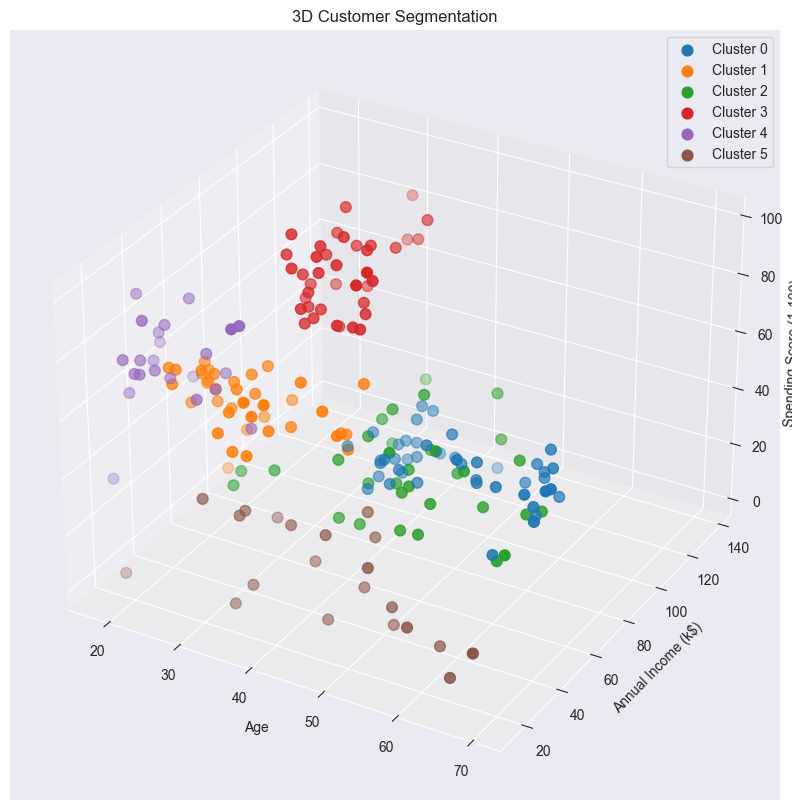

In [25]:
from mpl_toolkits.mplot3d import Axes3D

def clustering_3D(df, k=6):
    """
    3D Clustering with Matplotlib
    """
    # 1. Scaling & Clustering
    features_3d = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
    scaler = StandardScaler()
    X_3d_scaled = scaler.fit_transform(df[features_3d])

    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    df['Cluster_3D'] = kmeans.fit_predict(X_3d_scaled)

    # Drawing the 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot( projection='3d')

    # Separating the spots per cluster
    for cluster in range(k):
        clustered_data = df[df['Cluster_3D'] == cluster]
        ax.scatter(clustered_data['Age'],
                   clustered_data['Annual Income (k$)'],
                   clustered_data['Spending Score (1-100)'],
                   label=f'Cluster {cluster}', s=60)

    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income (k$)')
    ax.set_zlabel('Spending Score (1-100)')
    ax.set_title('3D Customer Segmentation')
    ax.legend()
    plt.show()

    return df


df = clustering_3D(df)

# Messing Around with this  3D Library

In [26]:
import plotly.express as px # Messing Around with this  3D Library

def perform_3d_clustering(df, k=6):
    """
    Performs 3d clustering and gives as interaction with the plot
    """
    # Selection of the features
    features_3d = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

    #  Scaling
    scaler = StandardScaler()
    X_3d_scaled = scaler.fit_transform(df[features_3d])

    #  KMeans
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    df['Cluster_3D'] = kmeans.fit_predict(X_3d_scaled)

    #  3D Scatter Plot
    fig = px.scatter_3d(
        df,
        x='Age',
        y='Annual Income (k$)',
        z='Spending Score (1-100)',
        color='Cluster_3D',
        title=f'3D Customer Segmentation (k={k})',
        labels={'Cluster_3D': 'Cluster ID'},
        opacity=0.8
    )

    fig.show(renderer='browser') # We show the Scatter Plot In Full Screen
    return df


df = perform_3d_clustering(df)

# Conclusion
- First we uploaded the data and checked the distribution and the outliers in each feature in the Univariate Analysis

- In the Multivariate Analysis we saw a negative correlation (-0.33) between Age and spending score. That means, bigger the age smallest the Spending Score.The other features had small correlation with the Spending Score, but we also checked the Annual Income

- In the Pair Annual Income VS Spending Score we found the optimal k=5 both with Elbow Method and Silhouette Score.

- In the Pair Age Vs Spending Score  with used k=6, although it has lower Silhouette Score that  k=2 but made better sense in the scatter plot.

### For the Marketing Section

- As we saw from the clustering Annual Income VS Spending Score, we have a cluster with High score that has big Spending score. But also we have some High Annual Incomers that have a low Spending Score, and maybe we need to get their attention
- Also we have Low Annual Incomers but with high Spending Score. In the 3D plot we saw these are the youngest customers. As we saw in the 2D plot Age VS Spending Score generally the younger persons have higher Spending Score.

- As we saw in both 2D plots the backbone of the company are the middle Spending Score, both in Age and Annual Income
